# **IMPORT LIBRARIES AND READ FILE**

In [84]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

In [85]:
url = 'https://raw.githubusercontent.com/Cloudyum/E-Commerce-Customer-Churn-Prediction-Data-Mining/refs/heads/main/output/cleaned_data.csv'

df = pd.read_csv('https://raw.githubusercontent.com/Cloudyum/E-Commerce-Customer-Churn-Prediction-Data-Mining/refs/heads/main/output/cleaned_data.csv')

df.head()
df.info()
df.describe()

#DOUBLE-CHECK DATA
print(df.isna().sum())
print(df['Churn'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CustomerID                             5630 non-null   int64  
 1   Churn                                  5630 non-null   int64  
 2   Tenure                                 5630 non-null   float64
 3   CityTier                               5630 non-null   int64  
 4   WarehouseToHome                        5630 non-null   float64
 5   HourSpendOnApp                         5630 non-null   float64
 6   NumberOfDeviceRegistered               5630 non-null   int64  
 7   SatisfactionScore                      5630 non-null   int64  
 8   NumberOfAddress                        5630 non-null   int64  
 9   Complain                               5630 non-null   int64  
 10  OrderAmountHikeFromlastYear            5630 non-null   float64
 11  Coup

Bisa kita lihat bahwa datanya masih imbalance atau tidak seimbang, karena customer yang tidak churn (dilambangkan oleh '0') memiliki angka yang lebih tinggi yaitu 0.83 daripada customer yang churn (dilambangkan oleh angka '1') yaitu 0.17

# **CHOOSING TARGET**

In [86]:
target_col = 'Churn'
X = df.drop(target_col, axis=1)
y = df[target_col]

# **SPLITTING DATA**

In [87]:
# 70% train, 30% sisa
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# 2) Dari 30%, dibagi jadi 15% val + 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (3941, 30), Val: (844, 30), Test: (845, 30)


# **SAMPLING DATA**

In [88]:
# NOTE: hanya pada training data saja
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nDistribusi setelah SMOTE:")
print(y_train_res.value_counts())


Distribusi setelah SMOTE:
Churn
0    3277
1    3277
Name: count, dtype: int64


# **STANDARIZATION**

In [89]:
rf_model = RandomForestClassifier(random_state=42)

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000))
])

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', probability=True, class_weight='balanced'))
])

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

lgbm_model = LGBMClassifier(random_state=42)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# **CROSS VALIDATION**

In [90]:
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__solver": ["lbfgs", "liblinear"]
    },
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "LightGBM": {
        "n_estimators": [100, 200],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"]
    }
}

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# **TUNING PARAMETER**

In [91]:
def tune_model_once(model, name, X_train, y_train):
    """Hyperparameter tuning sekali per model"""
    if name not in param_grids:
        print(f"Tidak ada param_grid untuk {name}, pakai default model.")
        return model

    print(f"\nTuning {name} ...")
    param_grid = param_grids[name]
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=cv_inner,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best params for {name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# **MODELING**

In [92]:
models = [
    (rf_model, "Random Forest"),
    (logreg_pipeline, "Logistic Regression"),
    (svm_pipeline, "SVM"),
    (xgb_model, "XGBoost"),
    (lgbm_model, "LightGBM"),
    (knn_pipeline, "KNN")
]

In [93]:
def evaluate_model_cv(model, name, X, y):
    acc_scores, prec_scores, rec_scores, f1_scores, roc_scores = [], [], [], [], []

    for train_idx, test_idx in cv_outer.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # fit model hasil tuning
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        # ROC AUC
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_fold)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test_fold)
        else:
            y_score = y_pred

        acc_scores.append(accuracy_score(y_test_fold, y_pred))
        prec_scores.append(precision_score(y_test_fold, y_pred))
        rec_scores.append(recall_score(y_test_fold, y_pred))
        f1_scores.append(f1_score(y_test_fold, y_pred))
        roc_scores.append(roc_auc_score(y_test_fold, y_score))

    metrics = {
        "Model": name,
        "Accuracy": np.mean(acc_scores),
        "Precision": np.mean(prec_scores),
        "Recall": np.mean(rec_scores),
        "F1 Score": np.mean(f1_scores),
        "ROC AUC": np.mean(roc_scores)
    }

    print(f"\n=== {name} (CV 5-Fold) ===")
    for k, v in metrics.items():
        if k != "Model":
            print(f"{k}: {v:.4f}")

    return metrics

In [94]:
tuned_models = []
for model, name in models:
    best_model = tune_model_once(model, name, X, y)
    tuned_models.append((best_model, name))

results_cv = []
for model, name in tuned_models:
    result = evaluate_model_cv(model, name, X, y)
    results_cv.append(result)


Tuning Random Forest ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuning Logistic Regression ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params for Logistic Regression: {'model__C': 1, 'model__solver': 'liblinear'}

Tuning SVM ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params for SVM: {'model__C': 10, 'model__gamma': 'scale'}

Tuning XGBoost ...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:18:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}

Tuning LightGBM ...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 948, number of negative: 4682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 5630, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168384 -> initscore=-1.597126
[LightGBM] [Info] Start training from score -1.597126
Best params for LightGBM: {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 200}

Tuning KNN ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params for KNN: {'model__n_neig

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:19:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:19:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:19:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:19:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:19:45] WARNING: /w


=== XGBoost (CV 5-Fold) ===
Accuracy: 0.9730
Precision: 0.9474
Recall: 0.8893
F1 Score: 0.9171
ROC AUC: 0.9888
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 758, number of negative: 3746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4504, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168295 -> initscore=-1.597760
[LightGBM] [Info] Start training from score -1.597760
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 758, number of negative: 3746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You

# **EVALUATION**

In [95]:
results_cv_df = pd.DataFrame(results_cv).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

print("Hasil Akhir Setelah Hyperparameter Tuning:")
print(results_cv_df)

Hasil Akhir Setelah Hyperparameter Tuning:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0             LightGBM  0.977798   0.956874  0.909284  0.932150  0.991756
1              XGBoost  0.973002   0.947366  0.889256  0.917088  0.988793
2                  SVM  0.955417   0.841968  0.905107  0.871934  0.978936
3        Random Forest  0.957549   0.950003  0.790170  0.861496  0.986856
4                  KNN  0.939432   0.867135  0.758485  0.807786  0.954843
5  Logistic Regression  0.894139   0.767740  0.532732  0.628729  0.890458


# **SAVE FILE**

In [96]:
import joblib
joblib.dump(best_model, "best_lightgbm.pkl")

['best_lightgbm.pkl']

# **MODELING OLD**

Random Forest Accuracy: 0.9476021314387212
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       936
           1       0.96      0.72      0.82       190

    accuracy                           0.95      1126
   macro avg       0.95      0.86      0.90      1126
weighted avg       0.95      0.95      0.94      1126



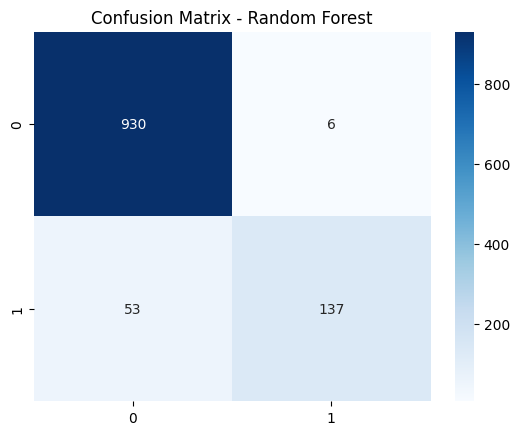

In [35]:
#RANDOM FOREST

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Logistic Regression Accuracy: 0.8969804618117229
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       936
           1       0.78      0.54      0.64       190

    accuracy                           0.90      1126
   macro avg       0.85      0.75      0.79      1126
weighted avg       0.89      0.90      0.89      1126



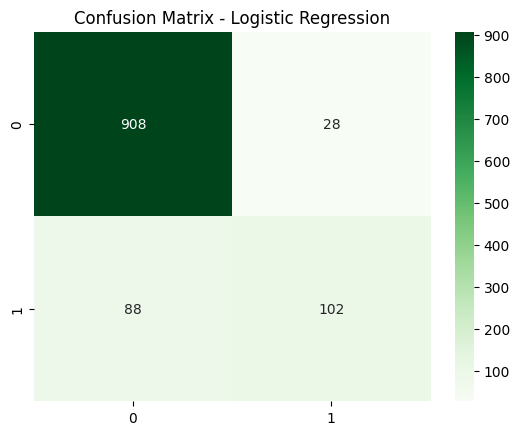

In [36]:
#LOGISTIC REGRESSION

logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_log = logreg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

SVM Accuracy: 0.9120781527531083
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       936
           1       0.88      0.56      0.68       190

    accuracy                           0.91      1126
   macro avg       0.90      0.77      0.82      1126
weighted avg       0.91      0.91      0.90      1126



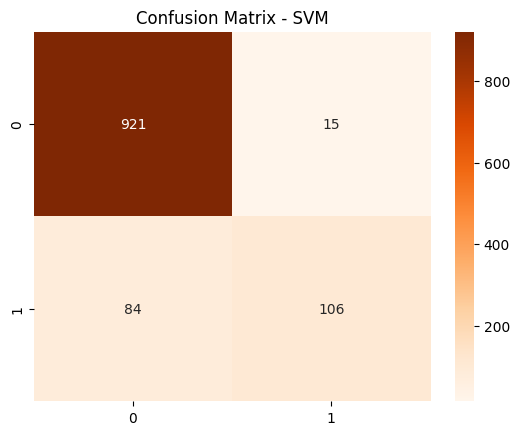

In [37]:
# SVM

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - SVM')
plt.show()